# 2D Auto Measurement

pyglet, trimesh

In [5]:
img_dir = "..\\..\\sample_data\\input\\16.jpg"
ht = 185

In [2]:
def dist(a,b,c,d):
  return ((d-b)**2 + (c-a)**2)**0.5

def neck_pts(mask,n_p):
  vlid_r = False
  valid_l = False
  for a in range(int(n_p[0]),np.shape(mask)[1]):
    if(mask[int(n_p[1])][a]) == 0:
      right = a
      valid_r = True
      break
  for a in range(int(n_p[0]))[::-1]:
    if(mask[int(n_p[1])][a]) == 0:
      left = a
      valid_l = True
      break
  if(not(valid_r) or not(valid_l)):
    print("Invalid")
    return 0,0
  return right,left

def ht_pts(seg,f):
  temp = sum(np.transpose(seg))
  valid_top = False
  valid_bot = False
  factor = f / 100 * np.shape(seg)[1]
  for a in (range(len(temp))):
    if temp[a] > factor:
      top = a 
      valid_top = True
      break
  temp = temp[::-1]
  for a in (range(len(temp))):
    if temp[a] > factor:
      bottom = np.shape(seg)[0]-a
      valid_bot = True
      break
  mid = int((bottom - top)/2) + top
  if(not(valid_top) or not(valid_bot)):
    print("Invalid")
    return 0,0

  temp = seg
#   temp[[top,bottom,mid],:] = 1

  plt.imshow(temp)
  plt.show()
  return top,bottom

def convert_to_int(image, joints):
    # convert image float to int
    if image.min() < 0. and image.max() < 2.:
        image = ((image + 1) / 2 * 255).astype(np.uint8)

    # convert joints float to int
    if np.issubdtype(joints.dtype, np.floating):
        if joints.min() < 0. and joints.max() < 2.:
            joints = _convert_joints(joints, image.shape[:2])
        else:
            joints = np.round(joints).astype(np.int32)

    return image, joints

def _convert_joints(joints, img_shape):
    return ((joints + 1) / 2 * img_shape).astype(np.int32)

## Segmentation

In [3]:
import os
import sys
import tarfile
from six.moves import urllib
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
import cv2, pdb, glob, argparse
import tensorflow as tf



class DeepLabModel(object):
	"""Class to load deeplab model and run inference."""

	INPUT_TENSOR_NAME = 'ImageTensor:0'
	OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
	INPUT_SIZE = 513
	FROZEN_GRAPH_NAME = 'frozen_inference_graph'

	def __init__(self, tarball_path):
		#"""Creates and loads pretrained deeplab model."""
		self.graph = tf.Graph()
		graph_def = None
		# Extract frozen graph from tar archive.
		tar_file = tarfile.open(tarball_path)
		for tar_info in tar_file.getmembers():
			if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
				file_handle = tar_file.extractfile(tar_info)
				graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
				break

		tar_file.close()

		if graph_def is None:
			raise RuntimeError('Cannot find inference graph in tar archive.')

		with self.graph.as_default():
			tf.import_graph_def(graph_def, name='')

		self.sess = tf.compat.v1.Session(graph=self.graph)

	def run(self, image):
		"""Runs inference on a single image.

		Args:
		  image: A PIL.Image object, raw input image.

		Returns:
		  resized_image: RGB image resized from original input image.
		  seg_map: Segmentation map of `resized_image`.
		"""
		width, height = image.size
		resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
		target_size = (int(resize_ratio * width), int(resize_ratio * height))
		resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
		batch_seg_map = self.sess.run(
			self.OUTPUT_TENSOR_NAME,
			feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
		seg_map = batch_seg_map[0]
		return resized_image, seg_map

def create_pascal_label_colormap():
	"""Creates a label colormap used in PASCAL VOC segmentation benchmark.

	Returns:
	A Colormap for visualizing segmentation results.
	"""
	colormap = np.zeros((256, 3), dtype=int)
	ind = np.arange(256, dtype=int)

	for shift in reversed(range(8)):
		for channel in range(3):
		  colormap[:, channel] |= ((ind >> channel) & 1) << shift
		ind >>= 3

	return colormap

def label_to_color_image(label):
	"""Adds color defined by the dataset colormap to the label.

	Args:
	label: A 2D array with integer type, storing the segmentation label.

	Returns:
	result: A 2D array with floating type. The element of the array
	  is the color indexed by the corresponding element in the input label
	  to the PASCAL color map.

	Raises:
	ValueError: If label is not of rank 2 or its value is larger than color
	  map maximum entry.
	"""
	if label.ndim != 2:
		raise ValueError('Expect 2-D input label')

	colormap = create_pascal_label_colormap()

	if np.max(label) >= len(colormap):
		raise ValueError('label value too large.')

	return colormap[label]



# parser = argparse.ArgumentParser(description='Deeplab Segmentation')
# parser.add_argument('-i', '--input_dir', type=str, required=True,help='Directory to save the output results. (required)')
# parser.add_argument('-ht', '--height', type=int, required=True,help='Directory to save the output results. (required)')

# args=parser.parse_args()

# dir_name=args.input_dir;


## setup ####################

LABEL_NAMES = np.asarray([
	'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
	'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
	'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


MODEL_NAME = 'xception_coco_voctrainval'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
	'mobilenetv2_coco_voctrainaug':
		'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
	'mobilenetv2_coco_voctrainval':
		'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
	'xception_coco_voctrainaug':
		'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
	'xception_coco_voctrainval':
		'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = _MODEL_URLS[MODEL_NAME]

model_dir = 'deeplab_model'
if not os.path.exists(model_dir):
  tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
if not os.path.exists(download_path):
  print('downloading model to %s, this might take a while...' % download_path)
  urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], 
			     download_path)
  print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')




model loaded successfully!


In [6]:
image = Image.open(img_dir)
res_im,seg=MODEL.run(image)

In [7]:
seg=cv2.resize(seg.astype(np.uint8),image.size)
mask_sel=(seg==15).astype(np.float32)
mask = 255*mask_sel.astype(np.uint8)

img = 	np.array(image)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)   

res = cv2.bitwise_and(img,img,mask = mask)
bg_removed = res + (255 - cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)) 

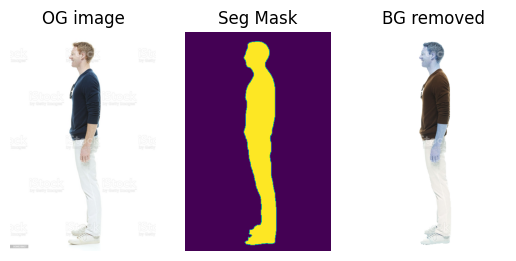

In [8]:
plt.subplot(131)
plt.title('OG image')
plt.imshow(res_im)
plt.axis('off')
plt.subplot(132)
plt.title('Seg Mask')
plt.imshow(seg)
plt.axis('off')
plt.subplot(133)
plt.title('BG removed')
plt.imshow(bg_removed)
plt.axis('off')
plt.savefig("..\\..\\out\\seg_op.jpg")
plt.show()

In [9]:
cv2.imwrite("..\\..\\out\\bg_rem_img.jpg",bg_removed)
cv2.imwrite("..\\..\\out\\seg_mask.jpg",mask)

True

## HMR

Use Tf == 2.3, Source: https://github.com/russoale/hmr2.0

In [20]:
# %cd /content/
# !mkdir logs
# !mkdir logs/paired
# %cd /content/logs/paired
# !wget https://github.com/russoale/hmr2.0/releases/download/2.0/base_model.paired.zip
# !unzip base_model.paired.zip
# %cd /content/
# !git clone https://github.com/russoale/hmr2.0.git
# %cd hmr2.0/src
# !pip install trimesh

In [10]:
import sys
print(sys.executable, sys.version)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from os import mkdir
from IPython.display import display, HTML
from glob import glob
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl
from main.local import LocalConfig

from visualise.vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose, preprocess_image, resize_img, visualize

C:\Users\Sathiya\miniconda3\envs\TensorFlow-GPU\python.exe 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]


In [11]:
class TrimeshConfig(LocalConfig):
        BATCH_SIZE = 1
        ENCODER_ONLY = True
        LOG_DIR = abspath('..\\..\\logs\\paired\\base_model')
        
config = TrimeshConfig()

In [12]:
# inizialize model 
model = Model()

Saving logs to f:\Projects\Body Measurement\Current\logs\paired\base_model

Configurations:
BATCH_SIZE                     1
CUSTOM_REGRESSOR_IDX           {0: 'regressor_test.npy'}
CUSTOM_REGRESSOR_PATH          f:\Projects\Body Measurement\Current\hmr2.0\src\tests\files\regressors
DATASETS                       ['dataset']
DATA_DIR                       f:\Projects\Body Measurement\Current\hmr2.0\src\tests\files
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
DS_KP2D                        {'lsp': 14, 'cocoplus': 19, 'custom': 21}
DS_KP3D                        {'lsp': 14, 'cocoplus': 14, 'custom': 16}
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.0001
INITIALIZE_CUSTOM_REGRESSOR    False
ITERATIONS                  

In [13]:
# ori, inp, param = preprocess_image('..\\..\\sample_data\\input\\arsalan2.jpeg',224)
# # ori2, inp2, param2 = preprocess_image('/content/hmr2.0/src/visualise/images/coco2.png',224)

In [14]:
ori, inp, param = preprocess_image("..\\..\\out\\bg_rem_img.jpg",224)

Resizing image to 224


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



True

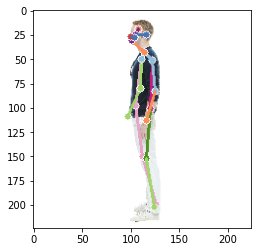

In [15]:
input_frames = [inp]
results = []
joints = []
vertices = []
img_2ds = []
cams = []

for image in input_frames:
    result = model.detect(image)
    results.append(result)
    joint = np.squeeze(result['kp2d'].numpy())
    joints.append(joint)
    np.save('..\\..\\out\\joints.npy',joints)
    img_2ds.append(draw_2d_on_image(image, joint))
    cams.append(np.squeeze(result['cam'].numpy())[:3])
    vertices.append(np.squeeze(result['vertices'].numpy()))

# f, ax = plt.subplots(1,2)
# ax[0].imshow(img_2ds[0])
# ax[1].imshow(img_2ds[1])

plt.imshow(img_2ds[0])
cv2.imwrite("..\\..\\out\\joints_plot.jpg",img_2ds[0])
# f.set_size_inches(20,20)

In [16]:
from visualise.trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

mesh = renderer.mesh(vertices[0])
mesh.show()

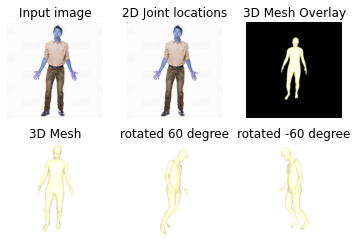

In [27]:
visualize(renderer, img, param, vertices[0], cams[0], joints[0])

## Feature Points

In [28]:
np.shape(joints)

(1, 19, 2)

In [17]:
joints = joints[0]

In [18]:
img, joints = convert_to_int(inp, joints)

    0: Right ankle
    1: Right knee
    2: Right hip
    3: Left hip
    4: Left knee
    5: Left ankle
    6: Right wrist
    7: Right elbow
    8: Right shoulder
    9: Left shoulder
    10: Left elbow
    11: Left wrist
    12: Neck
    13: Head top
    14: nose
    15: left_eye
    16: right_eye
    17: left_ear
    18: right_ear

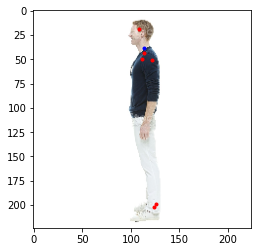

In [27]:
neck_shift_factor = 0.025
plt.imshow(img)
for i in [0,5,8,9,12,13]:
  plt.plot(joints[i][0], joints[i][1], marker='.', color="red")
plt.plot(joints[12][0], joints[12][1]-ht_p*neck_shift_factor, marker='.', color="blue")
plt.show()

In [20]:
def preprocess_gray(mask):
    img_size = 224
    scale = (float(img_size) / np.max(mask.shape[:2]))
    mask_scaled, actual_factor = resize_img(mask, scale)
    center = np.round(np.array(mask_scaled.shape[:2]) / 2).astype(int)
    center = center[::-1]  # image center in (x,y)

    margin = int(img_size / 2)
    image_pad = np.pad(mask_scaled, ((margin,), (margin,)), mode='edge')
    center_pad = center + margin
    start = center_pad - margin
    end = center_pad + margin

    crop = image_pad[start[1]:end[1], start[0]:end[0]]
    return crop

In [21]:
mask_scaled = preprocess_gray(mask)

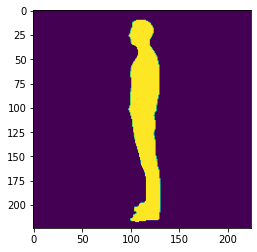

In [22]:
plt.imshow(mask_scaled)

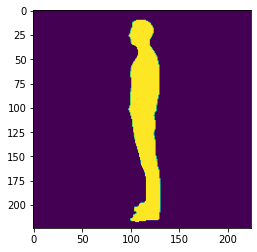

10 218


In [23]:
ht_factor = 5
top, bottom  = ht_pts(mask_scaled,ht_factor)
print(top,bottom)

In [24]:
ht_p = (joints[0][1]+joints[5][1])/2 - top
neck_shift_factor = 0.025

In [30]:
# mask_crop = crop[joints[13][1]:int((joints[8][1]+joints[9][1])/2),joints[8][0]:joints[9][0]]
# mask_crop = mask_scaled[top:int((joints[8][1]+joints[9][1])/2),joints[8][0]:joints[9][0]] #front
mask_crop = mask_scaled[top:int((joints[8][1]+joints[9][1])/2),int(joints[8][0]-ht_p*0.05):int(joints[9][0]+ht_p*0.05)] #side

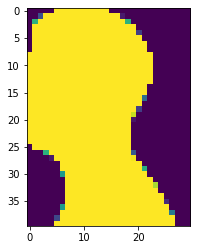

In [31]:
plt.imshow(mask_crop)

### Corner Detection - for neck

In [41]:
import cv2
import numpy as np

image = mask
# operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
operatedImage = image
operatedImage = np.float32(operatedImage)
  
dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07)
  
# Results are marked through the dilated corners
dest = cv2.dilate(dest, None)
  
# Reverting back to the original image,
# with optimal threshold value
out = np.zeros((np.shape(image)))
dest[dest > 0.01 * dest.max()]=[255]
# the window showing output image with corners
cv2.imshow('Image with Borders', dest)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
dest_scaled = preprocess_gray(dest)

In [36]:
# dest_crop = dest_scaled[joints[13][1]:int((joints[8][1]+joints[9][1])/2),joints[8][0]:joints[9][0]] # front
dest_crop = dest_scaled[joints[13][1]:int((joints[8][1]+joints[9][1])/2),int(joints[8][0]-ht_p*0.05):int(joints[9][0]+ht_p*0.05)] # side


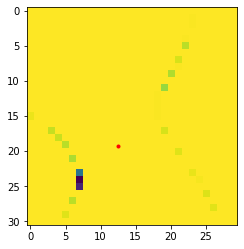

In [39]:
plt.imshow(dest_crop)
# plt.plot(joints[12][0]-joints[8][0], joints[12][1]-ht_p*neck_shift_factor-joints[13][1], marker='.', color="red") #front
plt.plot(joints[12][0]-joints[8][0]+ht_p*0.05, joints[12][1]-ht_p*neck_shift_factor-joints[13][1], marker='.', color="red") #side

In [42]:
def shortest_neck(dest_crop, sn_p):
    min_r, min_l = 10000, 10000
    r,l = [0,0],[0,0]
    if len(dest_crop)==0:
        print("Invalid crop")
        return 0,0
    for a in range(len(dest_crop)):
        for b in range(len(dest_crop[0])):
            if abs(dest_crop[a][b]) > 0:
                if b <= sn_p[0]:
                    if dist(a,b,sn_p[0],sn_p[1])<=min_l:
                        min_l = dist(a,b,sn_p[0],sn_p[1])
                        l = [a,b]
                else:
                    if dist(a,b,sn_p[0],sn_p[1])<=min_r:
                        min_r = dist(a,b,sn_p[0],sn_p[1])
                        r = [a,b]
    return r,l

In [43]:
# joints[12][0]-joints[8][0], joints[12][1]-ht_p*neck_shift_factor-joints[13][1] #front
joints[12][0]-joints[8][0]+ht_p*0.05, joints[12][1]-ht_p*neck_shift_factor-joints[13][1] #side

(12.525, 19.237499999999997)

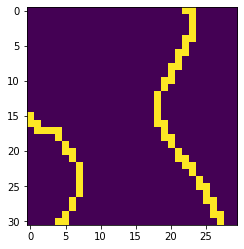

In [44]:
norm = abs(dest_crop)>0
plt.imshow(norm)

In [48]:
# r_neck, l_neck = shortest_neck(norm,[joints[12][0]-joints[8][0], joints[12][1]-ht_p*neck_shift_factor-joints[13][1]]) #front
r_neck, l_neck = shortest_neck(norm,[joints[12][0]-joints[8][0]+ht_p*0.05, joints[12][1]-ht_p*neck_shift_factor-joints[13][1]]) #side
print(r_neck,l_neck)

[13, 18] [20, 6]


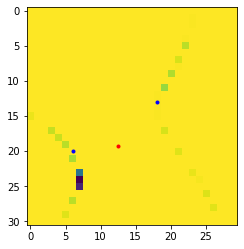

In [49]:
plt.imshow(dest_crop)
# plt.plot(joints[12][0]-joints[8][0], joints[12][1]-ht_p*neck_shift_factor-joints[13][1], marker='.', color="red") #front
plt.plot(joints[12][0]-joints[8][0]+ht_p*0.05, joints[12][1]-ht_p*neck_shift_factor-joints[13][1], marker='.', color="red") #side
plt.plot(r_neck[1],r_neck[0],marker = ".", color = 'blue')
plt.plot(l_neck[1],l_neck[0],marker = ".", color = 'blue')

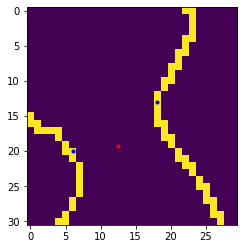

In [51]:
plt.imshow(norm)
plt.plot(r_neck[1],r_neck[0],marker = ".", color = 'blue')
plt.plot(l_neck[1],l_neck[0],marker = ".", color = 'blue')
# plt.plot(joints[12][0]-joints[8][0], joints[12][1]-ht_p*neck_shift_factor-joints[13][1], marker='.', color="red") #front
plt.plot(joints[12][0]-joints[8][0]+ht_p*0.05, joints[12][1]-ht_p*neck_shift_factor-joints[13][1], marker='.', color="red") #side

In [66]:
r_neck[1]

20

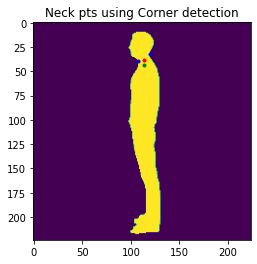

In [53]:
# r_neck_scaled = [r_neck[1]+joints[8][0],r_neck[0]+joints[13][1]] #front
# l_neck_scaled = [l_neck[1]+joints[8][0],l_neck[0]+joints[13][1]] #front
r_neck_scaled = [r_neck[1]+joints[8][0]-ht_p*0.05,r_neck[0]+joints[13][1]] #side
l_neck_scaled = [l_neck[1]+joints[8][0]-ht_p*0.05,l_neck[0]+joints[13][1]] #side
plt.imshow(mask_scaled)
plt.title('Neck pts using Corner detection')
plt.plot(r_neck_scaled[0],r_neck_scaled[1],marker = ".", color = 'blue')
plt.plot(l_neck_scaled[0],l_neck_scaled[1],marker = ".", color = 'blue')
plt.plot(joints[12][0], joints[12][1],marker = ".", color = 'green')
plt.plot(joints[12][0], joints[12][1]-ht_p*neck_shift_factor, marker='.', color="red")

## Measurement

In [55]:
arm_scale = 0.95
ht_scale = 1.04

# ht_p = ((joints[0][1]+joints[5][1])/2 - joints[13][1]) * ht_scale
# ht_p = (bottom - top)
ht_p = (joints[0][1]+joints[5][1])/2 - top
print("height in pixels: "+ str(ht_p))
lpp = ht / ht_p
print("Length per pixel(in cm): "+str(lpp))
# shoulder = (joints[9][0] - joints[8][0]) * lpp 

height in pixels: 194.5
Length per pixel(in cm): 0.9511568123393316


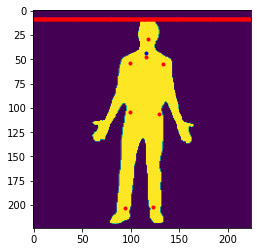

In [57]:
neck_shift_factor = 0.025
plt.imshow(mask_scaled)
for i in [0,2,3,5,8,9,12,13]:
  plt.plot(joints[i][0], joints[i][1], marker='.', color="red")
plt.plot(joints[12][0], joints[12][1]-ht_p*neck_shift_factor, marker='.', color="blue")
for i in range(224):
  plt.plot(i, top, marker='.', color="red")
plt.show()

In [59]:
shifted_neck = np.array([joints[12][0], joints[12][1]-ht_p*neck_shift_factor])
r,l = neck_pts(mask_scaled,shifted_neck)

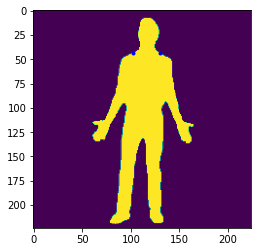

In [61]:
plt.imshow(mask_scaled)
plt.plot(r,shifted_neck[1], marker='.', color="blue")
plt.plot(l,shifted_neck[1], marker='.', color="blue")
plt.show()

In [54]:
def waist_pts(mask,n_p):
  valid_r = False
  valid_l = False
  for a in range(int(n_p[0]),np.shape(mask)[0]):
    if(mask[int(n_p[1])][a]) == 0:
      right = a
      valid_r = True
      break
  for a in range(int(n_p[0]))[::-1]:
    if(mask[int(n_p[1])][a]) == 0:
      left = a
      valid_l = True
      break
  if(not(valid_r) or not(valid_l)):
    print("Invalid")
    return 0,0
  return right,left

In [55]:
waist_shift_factor = 0.04
shifted_waist = np.array([joints[2][0]/2 + joints[3][0]/2, joints[2][1]/2 + joints[3][1]/2 - ht_p*waist_shift_factor])
r_waist,l_waist = waist_pts(mask_scaled,shifted_waist)

In [56]:
r_waist,l_waist

(129, 99)

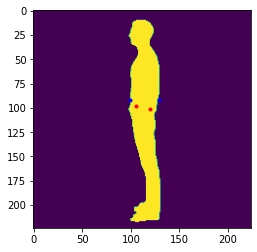

In [57]:
plt.imshow(mask_scaled)
plt.plot(r_waist,shifted_waist[1], marker='.', color="blue")
plt.plot(l_waist,shifted_waist[1], marker='.', color="blue")
for i in [2,3]:
  plt.plot(joints[i][0], joints[i][1], marker='.', color="red")
plt.show()

In [71]:
shoulder = dist(joints[8][0],joints[8][1],joints[9][0],joints[9][1])*lpp
arm = ((dist(joints[8][0],joints[8][1],joints[7][0],joints[7][1])+dist(joints[7][0],joints[7][1],joints[6][0],joints[6][1])
       +dist(joints[9][0],joints[9][1],joints[10][0],joints[10][1])+dist(joints[10][0],joints[10][1],joints[11][0],joints[11][1]))/2)*lpp * arm_scale
waist_f = dist(joints[2][0],joints[2][1],joints[3][0],joints[3][1])*lpp
neck_f = dist(r,shifted_neck[1],l,shifted_neck[1])*lpp
print("Length per pixel: "+str(lpp)+" cm")
print("Shoulder: "+str(shoulder)+" cm")
print("Arm: "+str(arm)+" cm")
print("Waist Front: "+str(waist_f)+" cm")
print("Neck Front: "+str(neck_f)+" cm")

Length per pixel: 0.9511568123393316 cm
Shoulder: 32.353316196026384 cm
Arm: 54.845720145506704 cm
Waist Front: 28.598044524411186 cm
Neck Front: 26.632390745501283 cm


## Hand Tracking

In [1]:
img_dir = "..\\..\\sample_data\\input\\arsalan2.jpeg"

In [72]:
import cv2
import mediapipe as mp
import time

# cap = cv2.VideoCapture(1)

mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

pTime = 0
cTime = 0

# success, img = cap.read()
img = cv2.imread(img_dir)
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = hands.process(imgRGB)
    # print(results.multi_hand_landmarks)

if results.multi_hand_landmarks:
    for handLms in results.multi_hand_landmarks:
        for id, lm in enumerate(handLms.landmark):
            # print(id, lm)
            h, w, c = img.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            print(id, cx, cy)
            # if id == 4:
            cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

        mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)

cTime = time.time()
fps = 1 / (cTime - pTime)
pTime = cTime

cv2.putText(img, str(int(fps)), (10, 70), cv2.FONT_HERSHEY_PLAIN, 3,
            (255, 0, 255), 3)

cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

0 397 639
1 380 628
2 364 627
3 349 628
4 334 624
5 361 659
6 344 674
7 335 685
8 328 695
9 371 670
10 357 690
11 348 703
12 342 715
13 383 675
14 373 695
15 366 708
16 358 720
17 397 675
18 394 693
19 394 704
20 392 715
0 823 654
1 842 647
2 857 644
3 870 643
4 883 636
5 851 674
6 862 695
7 866 705
8 870 714
9 841 681
10 851 704
11 855 717
12 859 728
13 829 683
14 835 705
15 839 718
16 843 731
17 816 682
18 815 698
19 815 709
20 816 720


In [8]:

import cv2
import mediapipe as mp
import time


class handDetector():
    def __init__(self, mode=False, maxHands=2, detectionCon=0.5, trackCon=0.5):
        self.mode = mode
        self.maxHands = maxHands
        self.detectionCon = detectionCon
        self.trackCon = trackCon

        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.maxHands,
                                        self.detectionCon, self.trackCon)
        self.mpDraw = mp.solutions.drawing_utils

    def findHands(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)
        # print(results.multi_hand_landmarks)

        if self.results.multi_hand_landmarks:
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(img, handLms,
                                               self.mpHands.HAND_CONNECTIONS)
        return img

    def findPosition(self, img, handNo=0, draw=True):

        lmList = []
        if self.results.multi_hand_landmarks:
            myHand = self.results.multi_hand_landmarks[handNo]
            for id, lm in enumerate(myHand.landmark):
                # print(id, lm)
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                # print(id, cx, cy)
                lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 15, (255, 0, 255), cv2.FILLED)

        return lmList

pTime = 0
cTime = 0
# cap = cv2.VideoCapture(1)
detector = handDetector()
img = cv2.imread(img_dir)

# success, img = cap.read()
img = detector.findHands(img)
lmList = detector.findPosition(img)
if len(lmList) != 0:
    print(lmList[4])

cTime = time.time()
fps = 1 / (cTime - pTime)
pTime = cTime

# cv2.putText(img, str(int(fps)), (10, 70), cv2.FONT_HERSHEY_PLAIN, 3,
#             (255, 0, 255), 3)

cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


[4, 652, 565]


CV co-ordinate extraction -- (For Dataset generation)

In [73]:
def click_event(event, x, y, flags, params):
  
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, ' ', y)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.imshow('image', img)

In [74]:
# img = cv2.imread('visualise\\images\\coco2.png', 1)
cv2.imshow('image', img)
cv2.setMouseCallback('image', click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

627   74
496   270
756   270
530   446
702   453
452   1163
694   1158
397   609
422   626
795   627
825   617
